Взять всех пользователей которые хотя бы раз задонатили в игру.

Разбить на 4 когорты органика/неорганика, ios/android

В каждом из основных регионов CIS и NA определить какой процент от всех платящих монетизируется в первые 24 часа жизни.

Сделать вывод какая из ключевых когорт в каждом регионе более монетизируема




In [2]:
n1=pd.read_sql(f'''
with data as
    (SELECT event_time, 
           min(event_time) filter (where event_name='FirstLaunchApp') OVER(PARTITION BY user_id) as date_install,
           event_name,user_id,
           user_type, 
           platform,
           case WHEN country in ('RU', 'AZ', 'AM', 'BY','KZ', 'KG','MD', 'TJ', 'UZ', 'UA', 'TM') then 'CIS'
                WHEN country in ('CA', 'US') then 'NA'
                     else 'Other' end as region,
           revenue_usd
    FROM data_viz_1068.project_dataset
    GROUP BY 1,3,4,5,6,7,8)
    
SELECT cast((count(distinct user_id) filter (where event_time <=(date_install+INTERVAL '1' DAY))) as float)/cast((count(distinct user_id)) as float)*100 as per_users,
       user_type, 
       platform,
       region,
       sum(revenue_usd) as all_revenue,
       sum(revenue_usd) filter (where event_time <=(date_install+INTERVAL '1' DAY)) as rev_f24
FROM data
WHERE date_install IS NOT NULL and event_name='af_purchase' and region!='Other' 
GROUP BY 2,3,4
''', con=engine)

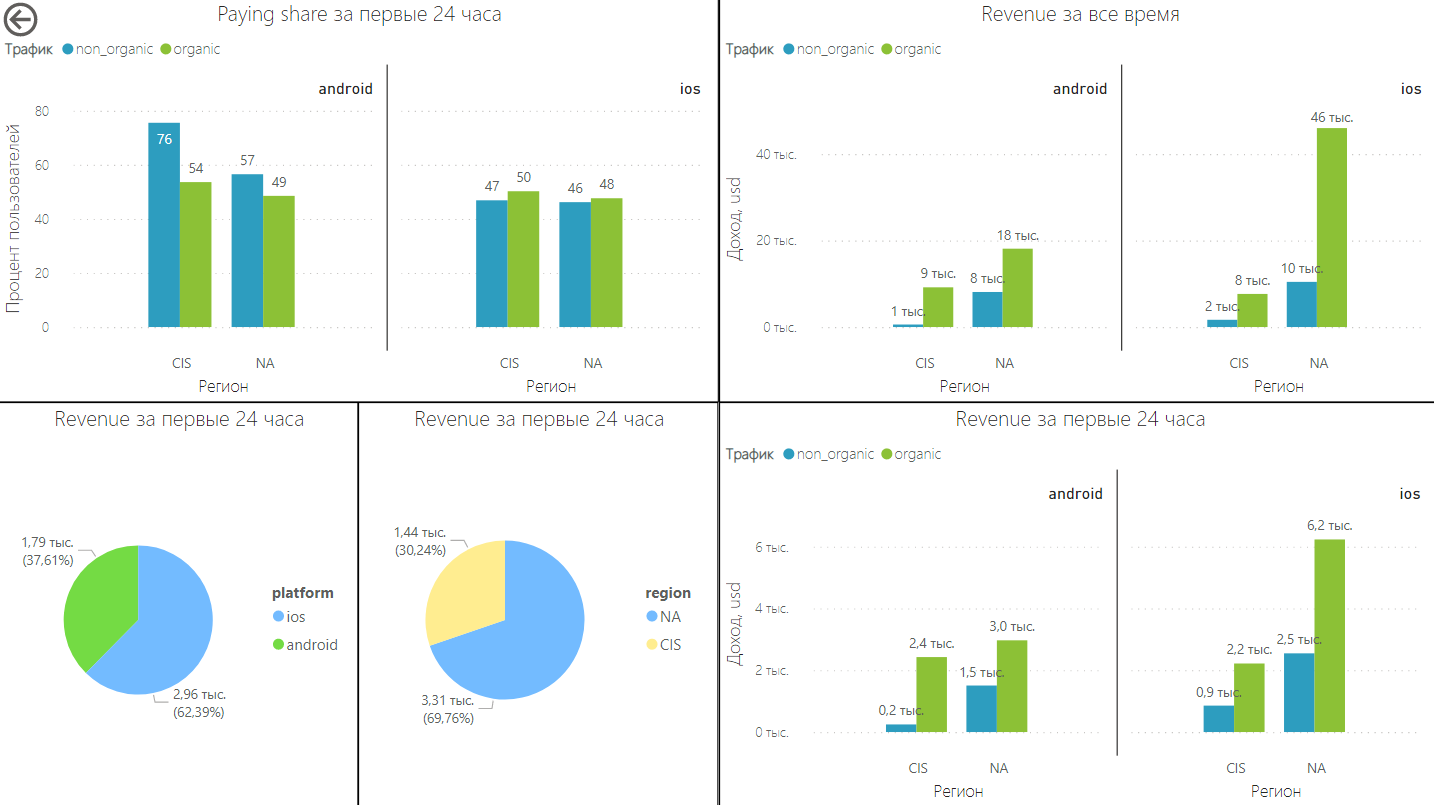

Вывод:
    
    Говоря о проценте платящих, которые монетизируется за первые 24 часа жизни, наибольший процент занимают неорганические пользователи из СНГ с платформы anroid (76%), но в тоже время данные игроки приносят меньше всего прибыли. Примерно в одинаковой степени монетизируются остальные когорты, от 46 до 57% пользователей вносят первый платеж в первые сутки. 
    За первые 24 часа после установки игры больше всего монетизируется Северная Америка на платформе IOS за счет органического трафика - в 3 раза больше второй по величине когорте (NA органического трафика на платформе anroid), достигая 6,2 тыс. дол. в среднем. Говоря об остальных когортах, то СНГ органического трафика на обеих платформах находится на одном уровне монетизации с неорганическим трафиком Северной Америким платформы IOS. Меньше всего приносят доход, как и было сказано, неорганические пользователи СНГ на платформе anroid. Говоря о монетизации за все время, то ее рост происходит в равном процентом соотношение, т.е. ситуация не особо меняется. 

Определить какой самый популярный пакет для первого платежа в каждом регионе, в каждой когорте. Ответить на вопрос - почему именно он?

In [15]:
n2=pd.read_sql(f'''
    SELECT distinct content_id, count(content_id) as count_content_id,user_type,platform,region
    FROM
    (SELECT event_time,content_id, 
            min(event_time) OVER(PARTITION BY user_id) as firstpay_time,
            user_type, 
            platform,
            case WHEN country in ('RU', 'AZ', 'AM', 'BY','KZ', 'KG','MD', 'TJ', 'UZ', 'UA', 'TM') then 'CIS'
                WHEN country in ('CA', 'US') then 'NA'
                     else 'Other' end as region
    FROM data_viz_1068.project_dataset
    WHERE event_name='af_purchase') as a
    WHERE event_time=firstpay_time 
    GROUP BY 1,3,4,5

''', con=engine)

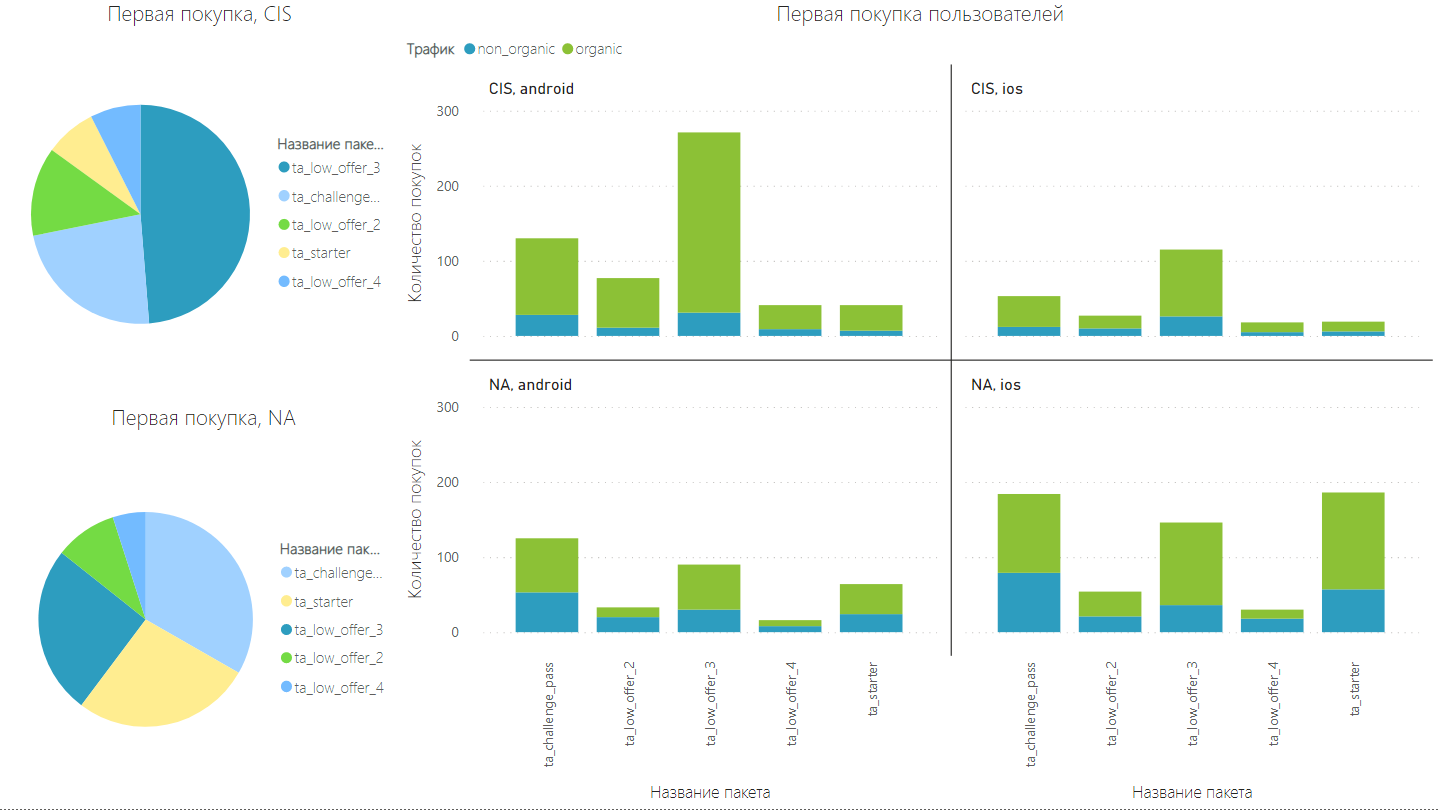

Вывод:
    
    В зависимости от регионов самые монетизируемые пакеты отличаются. В первые 24 часа игры пользователи СНГ предпочитают покупать ta_low_offer_3 (скорее всего один из видов спец предложений по низкой цене), почти 50% игроков, причем во всех когортах относительно СНГ.На втором месте в СНГ ta_challenge_pass (какой-то вид пропуска в игре).  Ситуация в Северной Америке другая: больше всего пользователи покупают ta_challenge_pass, в относительно равном объеме ta_starter (стартовый набор скорее всего) и ta_low_offer_3. Причем на anroid на втором месте ta_low_offer_3, а на ios ta_starter. Специальные предложения, стартовые наборы обычно имеют очень привлекательную цену для первой покупки, либо пользователей подталкивает ограничение по времени (как это делают в большинстве игр). Пропуски дают премиум контент на какое-либо ограниченной время, часто на неделю или месяц. 
    Относительно цен:
        1. ta_challenge_pass - 5-6$
        2. ta_starter - 12-13$
        3. ta_low_offer_3 1$ в среднем (остальные low_offer дороже 1$)
    Таким образом, ta_challenge_pass достаточно выгодное предложение для покупки.